> **Problem overview**

This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset. You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?

In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

# import model selection from sklearn
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
train_df = pd.read_csv('../input/train.csv', parse_dates=['date'], index_col='date')
test_df = pd.read_csv('../input/test.csv', parse_dates=['date'], index_col='date')

In [3]:
# visualize head of the training data
train_df.head(n=3)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14


In [4]:
# visualize tail of the testing data
test_df.tail(n=3)

,id,store,item
date,,,
2018-03-29,44997,10,50
2018-03-30,44998,10,50
2018-03-31,44999,10,50


In [5]:
# combine training and testing dataframe
train_df['datatype'], test_df['datatype'] = 'training', 'testing'
train_df.insert(0, 'id', 0)
test_df.insert(test_df.shape[1] - 1, 'sales', 0)
data_df = pd.concat([train_df, test_df])
data_df.head(n=3)

,id,store,item,sales,datatype
date,,,,,
2013-01-01,0,1,1,13,training
2013-01-02,0,1,1,11,training
2013-01-03,0,1,1,14,training


> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [6]:
# describe training and testing data
data_df.describe(include='all')

,id,store,item,sales,datatype
count,958000.000000,958000.000000,958000.000000,958000.000000,958000
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,training
freq,NaN,NaN,NaN,NaN,913000
mean,1056.865866,5.500000,25.500000,49.795942,NaN
std,5530.704311,2.872283,14.430877,30.211887,NaN
min,0.000000,1.000000,1.000000,0.000000,NaN
25%,0.000000,3.000000,13.000000,27.000000,NaN
50%,0.000000,5.500000,25.500000,45.000000,NaN
75%,0.000000,8.000000,38.000000,68.000000,NaN


In [7]:
# time series plot function
def timeplot(dfx, by = None, column = None):
    fig, ax = plt.subplots(figsize=(20, 5))
    dfx[column].plot()
    plt.tight_layout()
    plt.show()

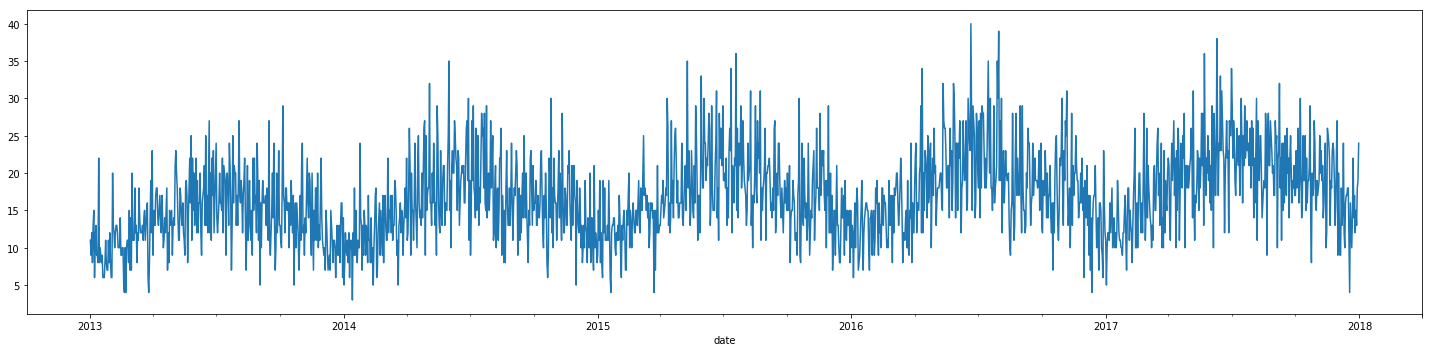

In [8]:
# time series plot for store 5 and item 1
train_storeitem_df = data_df[(data_df['store'] == 5) & (data_df['item'] == 1) & (data_df['datatype'] == 'training')]
timeplot = timeplot(train_storeitem_df, column='sales')

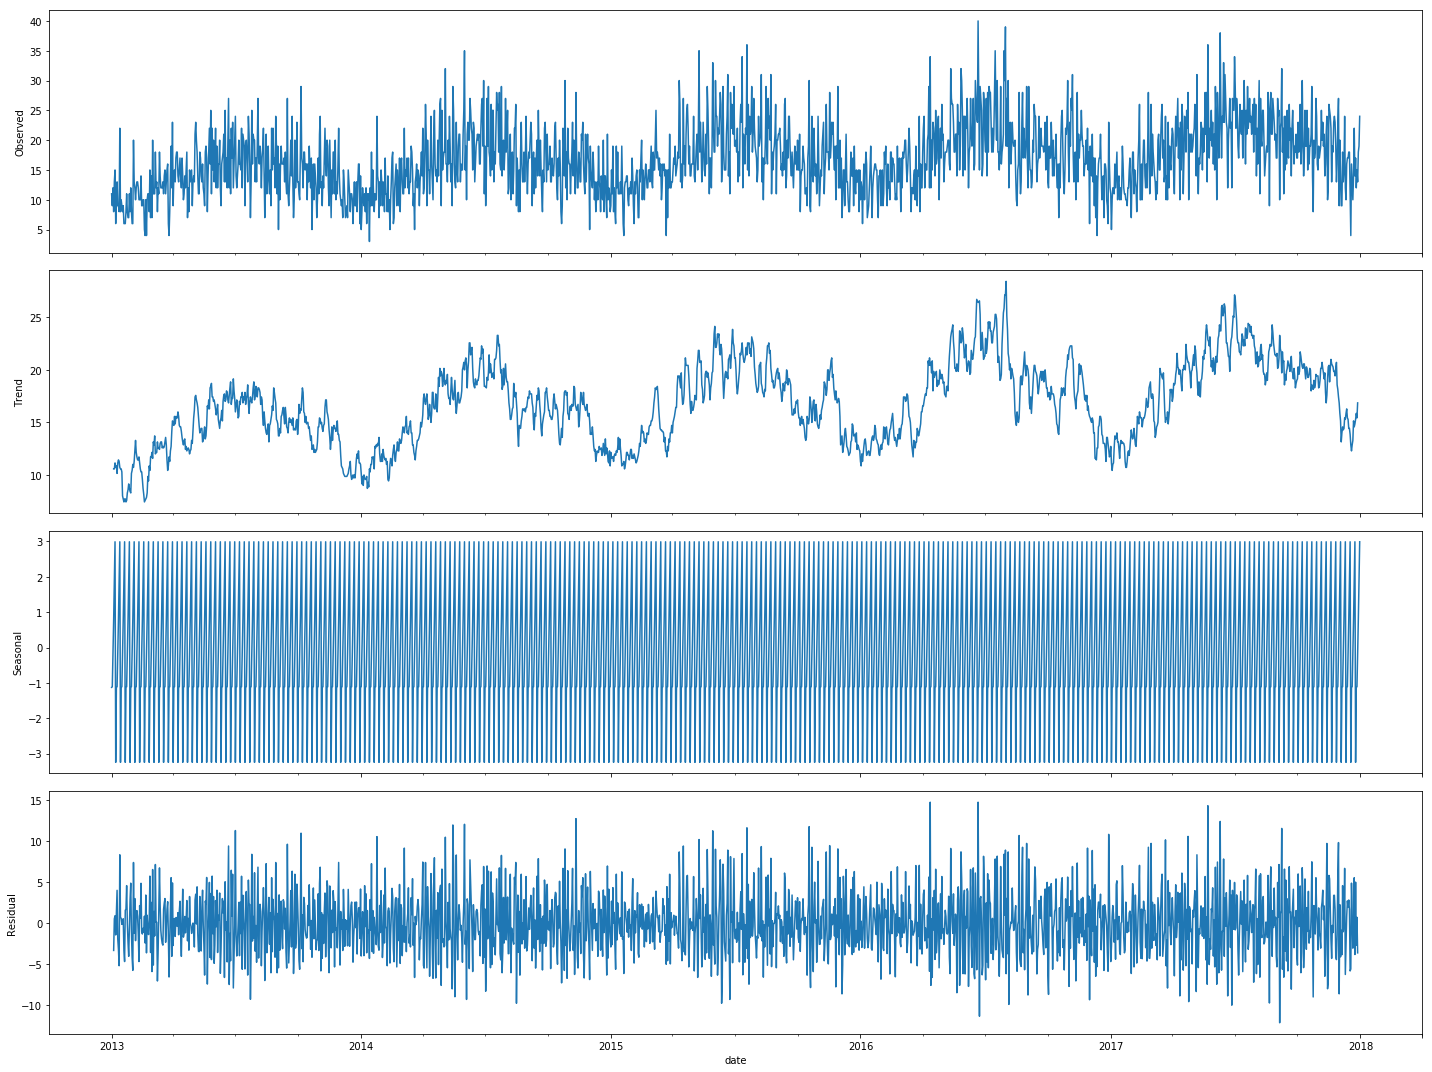

In [9]:
# seasonal decompose for store 5 and item 1
seasonal = sm.tsa.seasonal_decompose(train_storeitem_df.sales).plot()
seasonal.set_figheight(15)
seasonal.set_figwidth(20)
plt.tight_layout()
plt.show()

In [10]:
# feature extraction: combination of keyword date
data_df['date'] = data_df.index
data_df['year'] = data_df['date'].dt.year
data_df['quarter'] = data_df['date'].dt.quarter
data_df['month'] = data_df['date'].dt.month
data_df['weekofyear'] = data_df['date'].dt.weekofyear
data_df['dayofweek'] = data_df['date'].dt.dayofweek

In [11]:
# feature extraction: statistic features for quarter
data_df['itemquarter_mean'] = data_df.groupby(['quarter', 'item'])['sales'].transform('mean')
data_df['itemquarter_sum'] = data_df.groupby(['quarter', 'item'])['sales'].transform('sum')
data_df['storequarter_mean'] = data_df.groupby(['quarter', 'store'])['sales'].transform('mean')
data_df['storequarter_sum'] = data_df.groupby(['quarter', 'store'])['sales'].transform('sum')
data_df['storeitemquarter_mean'] = data_df.groupby(['quarter', 'item', 'store'])['sales'].transform('mean')
data_df['storeitemquarter_sum'] = data_df.groupby(['quarter', 'item', 'store'])['sales'].transform('sum')

In [12]:
# feature extraction: statistic features for month
data_df['itemmonth_mean'] = data_df.groupby(['month', 'item'])['sales'].transform('mean')
data_df['itemmonth_sum'] = data_df.groupby(['month', 'item'])['sales'].transform('sum')
data_df['storemonth_mean'] = data_df.groupby(['month', 'store'])['sales'].transform('mean')
data_df['storemonth_sum'] = data_df.groupby(['month', 'store'])['sales'].transform('sum')
data_df['storeitemmonth_mean'] = data_df.groupby(['month', 'item', 'store'])['sales'].transform('mean')
data_df['storeitemmonth_sum'] = data_df.groupby(['month', 'item', 'store'])['sales'].transform('sum')

In [13]:
# feature extraction: statistic features for week
data_df['storeitemweekofyear_mean'] = data_df.groupby(['weekofyear', 'item', 'store'])['sales'].transform('mean')
data_df['storeitemweekofyear_sum'] = data_df.groupby(['weekofyear', 'item', 'store'])['sales'].transform('sum')

In [14]:
# feature extraction: shifted features for 90 days
data_df['storeitem_shift90'] = data_df.groupby(['item', 'store'])['sales'].transform(lambda x: x.shift(90))
data_df['storeitem_shift180'] = data_df.groupby(['item', 'store'])['sales'].transform(lambda x: x.shift(180))
data_df['storeitem_shift365'] = data_df.groupby(['item', 'store'])['sales'].transform(lambda x: x.shift(365))
data_df['itemweekofyear_shift90_mean'] = data_df.groupby(['weekofyear', 'item'])['sales'].transform(lambda x: x.shift(12).mean())
data_df['itemweekofyear_shift90_sum'] = data_df.groupby(['weekofyear', 'item'])['sales'].transform(lambda x: x.shift(12).sum())
data_df['storeweekofyear_shift90_mean'] = data_df.groupby(['weekofyear', 'store'])['sales'].transform(lambda x: x.shift(12).mean())
data_df['storeweekofyear_shift90_sum'] = data_df.groupby(['weekofyear', 'store'])['sales'].transform(lambda x: x.shift(12).sum())

In [15]:
data_df.tail(n=3)

,id,store,item,sales,datatype,date,year,quarter,month,weekofyear,dayofweek,itemquarter_mean,itemquarter_sum,storequarter_mean,storequarter_sum,storeitemquarter_mean,storeitemquarter_sum,itemmonth_mean,itemmonth_sum,storemonth_mean,storemonth_sum,storeitemmonth_mean,storeitemmonth_sum,storeitemweekofyear_mean,storeitemweekofyear_sum,storeitem_shift90,storeitem_shift180,storeitem_shift365,itemweekofyear_shift90_mean,itemweekofyear_shift90_sum,storeweekofyear_shift90_mean,storeweekofyear_shift90_sum
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-29,44997,10,50,0,testing,2018-03-29,2018,1,3,13,3,42.810166,231603,38.173715,1032599,48.131238,26039,49.789785,92609,44.298387,411975,56.483871,10506,58.707317,2407,74.0,103.0,73.0,54.01005,21496,47.046124,95880
2018-03-30,44998,10,50,0,testing,2018-03-30,2018,1,3,13,4,42.810166,231603,38.173715,1032599,48.131238,26039,49.789785,92609,44.298387,411975,56.483871,10506,58.707317,2407,62.0,99.0,68.0,54.01005,21496,47.046124,95880
2018-03-31,44999,10,50,0,testing,2018-03-31,2018,1,3,13,5,42.810166,231603,38.173715,1032599,48.131238,26039,49.789785,92609,44.298387,411975,56.483871,10506,58.707317,2407,82.0,71.0,69.0,54.01005,21496,47.046124,95880


After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [16]:
# verify dtypes object
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 958000 entries, 2013-01-01 to 2018-03-31
Data columns (total 32 columns):
id                              958000 non-null int64
store                           958000 non-null int64
item                            958000 non-null int64
sales                           958000 non-null int64
datatype                        958000 non-null object
date                            958000 non-null datetime64[ns]
year                            958000 non-null int64
quarter                         958000 non-null int64
month                           958000 non-null int64
weekofyear                      958000 non-null int64
dayofweek                       958000 non-null int64
itemquarter_mean                958000 non-null float64
itemquarter_sum                 958000 non-null int64
storequarter_mean               958000 non-null float64
storequarter_sum                958000 non-null int64
storeitemquarter_mean           958000 non-null f

In [17]:
# convert dtypes object to category
col_obj = data_df.select_dtypes(['object']).columns
data_df[col_obj] = data_df[col_obj].astype('category')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 958000 entries, 2013-01-01 to 2018-03-31
Data columns (total 32 columns):
id                              958000 non-null int64
store                           958000 non-null int64
item                            958000 non-null int64
sales                           958000 non-null int64
datatype                        958000 non-null category
date                            958000 non-null datetime64[ns]
year                            958000 non-null int64
quarter                         958000 non-null int64
month                           958000 non-null int64
weekofyear                      958000 non-null int64
dayofweek                       958000 non-null int64
itemquarter_mean                958000 non-null float64
itemquarter_sum                 958000 non-null int64
storequarter_mean               958000 non-null float64
storequarter_sum                958000 non-null int64
storeitemquarter_mean           958000 non-null

In [18]:
# convert dtypes category to category codes
col_cat = data_df.select_dtypes(['category']).columns
data_df[col_cat] = data_df[col_cat].apply(lambda x: x.cat.codes)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 958000 entries, 2013-01-01 to 2018-03-31
Data columns (total 32 columns):
id                              958000 non-null int64
store                           958000 non-null int64
item                            958000 non-null int64
sales                           958000 non-null int64
datatype                        958000 non-null int8
date                            958000 non-null datetime64[ns]
year                            958000 non-null int64
quarter                         958000 non-null int64
month                           958000 non-null int64
weekofyear                      958000 non-null int64
dayofweek                       958000 non-null int64
itemquarter_mean                958000 non-null float64
itemquarter_sum                 958000 non-null int64
storequarter_mean               958000 non-null float64
storequarter_sum                958000 non-null int64
storeitemquarter_mean           958000 non-null flo

In [19]:
data_df.head(n=3)

,id,store,item,sales,datatype,date,year,quarter,month,weekofyear,dayofweek,itemquarter_mean,itemquarter_sum,storequarter_mean,storequarter_sum,storeitemquarter_mean,storeitemquarter_sum,itemmonth_mean,itemmonth_sum,storemonth_mean,storemonth_sum,storeitemmonth_mean,storeitemmonth_sum,storeitemweekofyear_mean,storeitemweekofyear_sum,storeitem_shift90,storeitem_shift180,storeitem_shift365,itemweekofyear_shift90_mean,itemweekofyear_shift90_sum,storeweekofyear_shift90_mean,storeweekofyear_shift90_sum
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,1,13,1,2013-01-01,2013,1,1,1,1,14.209242,76872,30.723105,831060,12.783734,6916,12.358602,22987,26.812043,249352,11.424731,2125,11.585366,475,NaN,NaN,NaN,12.846734,5113,27.134446,55300
2013-01-02,0,1,1,11,1,2013-01-02,2013,1,1,1,2,14.209242,76872,30.723105,831060,12.783734,6916,12.358602,22987,26.812043,249352,11.424731,2125,11.585366,475,NaN,NaN,NaN,12.846734,5113,27.134446,55300
2013-01-03,0,1,1,14,1,2013-01-03,2013,1,1,1,3,14.209242,76872,30.723105,831060,12.783734,6916,12.358602,22987,26.812043,249352,11.424731,2125,11.585366,475,NaN,NaN,NaN,12.846734,5113,27.134446,55300


> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

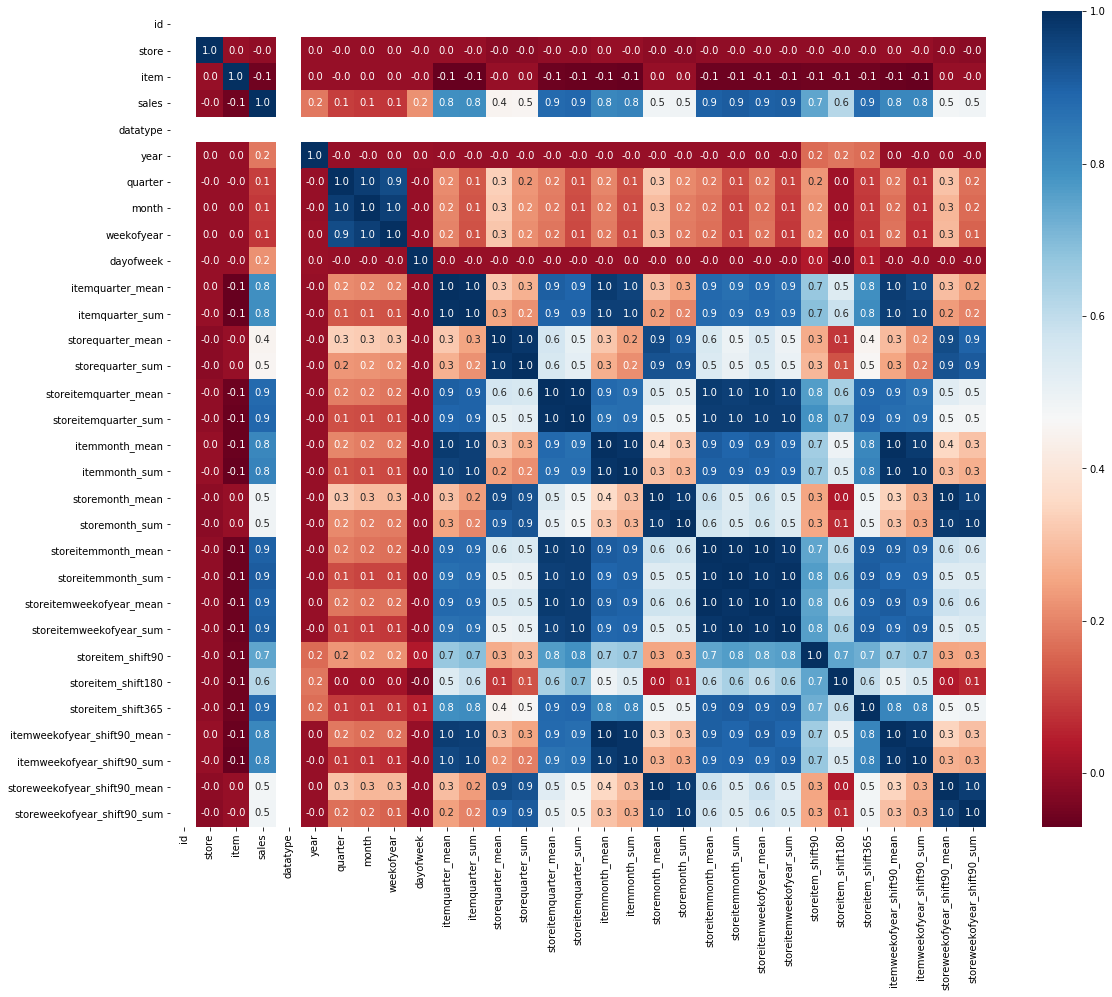

In [20]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = data_df[data_df['datatype'] == 1].corr()
fig, ax = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True);

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

In [21]:
# plot pairwise relationships in a dataset
#pairplot = sns.pairplot(data_df[data_df['datatype'] == 1], diag_kind='kde', diag_kws=dict(shade=True), hue='sales')

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [22]:
# select all features
x = data_df[data_df['datatype'] == 1].drop(['id', 'sales', 'datatype', 'date'], axis=1)
y = data_df[data_df['datatype'] == 1]['sales']

In [23]:
x.head(n=3)

,store,item,year,quarter,month,weekofyear,dayofweek,itemquarter_mean,itemquarter_sum,storequarter_mean,storequarter_sum,storeitemquarter_mean,storeitemquarter_sum,itemmonth_mean,itemmonth_sum,storemonth_mean,storemonth_sum,storeitemmonth_mean,storeitemmonth_sum,storeitemweekofyear_mean,storeitemweekofyear_sum,storeitem_shift90,storeitem_shift180,storeitem_shift365,itemweekofyear_shift90_mean,itemweekofyear_shift90_sum,storeweekofyear_shift90_mean,storeweekofyear_shift90_sum
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,2013,1,1,1,1,14.209242,76872,30.723105,831060,12.783734,6916,12.358602,22987,26.812043,249352,11.424731,2125,11.585366,475,NaN,NaN,NaN,12.846734,5113,27.134446,55300
2013-01-02,1,1,2013,1,1,1,2,14.209242,76872,30.723105,831060,12.783734,6916,12.358602,22987,26.812043,249352,11.424731,2125,11.585366,475,NaN,NaN,NaN,12.846734,5113,27.134446,55300
2013-01-03,1,1,2013,1,1,1,3,14.209242,76872,30.723105,831060,12.783734,6916,12.358602,22987,26.812043,249352,11.424731,2125,11.585366,475,NaN,NaN,NaN,12.846734,5113,27.134446,55300


In [24]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=0, test_size=0.25)

In [25]:
# model prediction
params = {
    'objective': 'reg:linear',
    'eta': 0.1,
    'max_depth': 6,
    'silent': 1,
    'eval_metric': 'mae',
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 0,
}
xgbtrain = xgb.DMatrix(x_train, label=y_train)
xgbvalidate = xgb.DMatrix(x_validate, label=y_validate)
xgbmodel = xgb.train(list(params.items()), xgbtrain, early_stopping_rounds=50, evals=[(xgbtrain, 'train'), (xgbvalidate, 'validate')], num_boost_round=500, verbose_eval=50)

[0]	train-mae:46.5732	validate-mae:46.5838
Multiple eval metrics have been passed: 'validate-mae' will be used for early stopping.

Will train until validate-mae hasn't improved in 50 rounds.
[50]	train-mae:5.54868	validate-mae:5.57946
[100]	train-mae:5.50523	validate-mae:5.55192
[150]	train-mae:5.48491	validate-mae:5.54608
[200]	train-mae:5.4682	validate-mae:5.54337
[250]	train-mae:5.45426	validate-mae:5.5423
[300]	train-mae:5.44135	validate-mae:5.543
Stopping. Best iteration:
[252]	train-mae:5.45343	validate-mae:5.54213



> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [26]:
# model selection
model = xgbmodel

# prepare testing data and compute the observed value
x_test = data_df[data_df['datatype'] == 0].drop(['id', 'sales', 'datatype', 'date'], axis=1)
y_test = pd.DataFrame(model.predict(xgb.DMatrix(x_test), ntree_limit=model.best_ntree_limit), columns=['sales'])

In [27]:
# summit the results
out = pd.DataFrame({'id': test_df.reset_index()['id'], 'sales': y_test['sales']})
out.to_csv('submission.csv', index=False)